In [1]:
# %pip install datasets
# %pip install 'accelerate>=0.26.0'
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install torch
# %pip install transformers
# %pip install scikit-learn
# %pip install datasets
# %pip install kagglehub
# %pip install ipywidgets
# %pip install pylatexenc

In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
import kagglehub

import warnings
warnings.filterwarnings('ignore')

##### LOAD DATA

#### Dataset from https://www.kaggle.com/datasets/lizhecheng/llm-science-dataset

In [ ]:
file_path = kagglehub.dataset_download("lizhecheng/llm-science-dataset")
data = pd.read_csv(f"{file_path}/High Quality Dataset.csv")
data.columns = data.columns.str.strip()

#### Data processing

In [ ]:
data['answer'] = data['answer'].str.strip().str.upper()
label_to_id = {label: idx for idx, label in enumerate(sorted(data['answer'].unique()))}
id_to_label = {v: k for k, v in label_to_id.items()}
data['label'] = data['answer'].map(label_to_id)

# FORMAT PROMPT WITH CHOICES
def format_prompt_with_correct_answer(row):
    option_letter = row['answer']
    if option_letter in ['A', 'B', 'C', 'D', 'E']:
        correct_text = row.get(option_letter, '[Missing]')
        return f"{row['prompt']}\nCorrect: {option_letter}: {correct_text}"
    else:
        return f"{row['prompt']}\nCorrect: {option_letter}: [Invalid answer]"

data['full_prompt'] = data.apply(format_prompt_with_correct_answer, axis=1)

# LABEL ENCODING
label_counts = Counter(data['label'])
valid_labels = [label for label, count in label_counts.items() if count > 1]
data = data[data['label'].isin(valid_labels)]

train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
train_df.to_csv("train_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)

X_train = train_df['full_prompt'].values
y_train = train_df['label'].values
X_test = test_df['full_prompt'].values
y_test = test_df['label'].values

#### Tokenization

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=256)

train_data = {'text': X_train, 'label': y_train}
test_data = {'text': X_test, 'label': y_test}

train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/7068 [00:00<?, ? examples/s]

Map:   0%|          | 0/1767 [00:00<?, ? examples/s]

#### Model and Training Arguments

In [4]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label_to_id),
)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    logging_dir="./logs",
    logging_steps=10,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Train the Model

In [5]:
print("Starting NLP Training...")
trainer.train()

results = trainer.evaluate()
print("Evaluation Results:", results)

Starting NLP Training...


Epoch,Training Loss,Validation Loss
1,0.000600,0.000407
2,0.000300,0.000176
3,0.000300,0.000123
4,0.000100,0.000088
5,0.000100,0.000080


Evaluation Results: {'eval_loss': 8.046704897424206e-05, 'eval_runtime': 29.5699, 'eval_samples_per_second': 59.757, 'eval_steps_per_second': 3.754, 'epoch': 5.0}


#### Inference

In [6]:
device = torch.device("mps" if torch.has_mps else "cpu")
model.to(device)

def predict(texts):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=256, return_tensors="pt")
    encodings = {key: val.to(device) for key, val in encodings.items()}
    with torch.no_grad():
        outputs = model(**encodings)
        predictions = torch.argmax(outputs.logits, dim=1)
    return [id_to_label[pred.item()] for pred in predictions]

#### Example Inference

In [7]:
sample_texts = ["What is quantum entanglement?", "Explain Modified Newtonian Dynamics."]
predictions = predict(sample_texts)
print("Predictions:", predictions)

Predictions: ['A', 'C']


#### Evaluate with Test Data

In [8]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

y_pred_labels = [id_to_label[pred] for pred in y_pred]
y_true_labels = [id_to_label[true] for true in y_true]

accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 1.0000


In [9]:
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels))

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
print("\nConfusion Matrix:")
print(conf_matrix)


Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       426
           B       1.00      1.00      1.00       363
           C       1.00      1.00      1.00       350
           D       1.00      1.00      1.00       322
           E       1.00      1.00      1.00       306

    accuracy                           1.00      1767
   macro avg       1.00      1.00      1.00      1767
weighted avg       1.00      1.00      1.00      1767


Confusion Matrix:
[[426   0   0   0   0]
 [  0 363   0   0   0]
 [  0   0 350   0   0]
 [  0   0   0 322   0]
 [  0   0   0   0 306]]


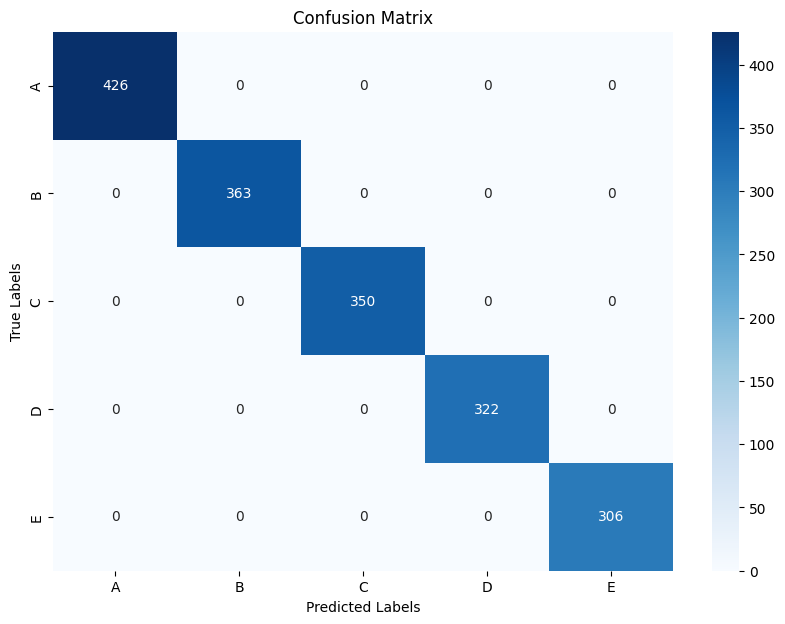

In [10]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.unique(y_true_labels), 
            yticklabels=np.unique(y_true_labels))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()